# Random Forest Classification Model (Clean Version - Mateo)

Ce notebook utilise l'utilitaire DataPreprocessor pour préparer les données et entraîner un modèle Random Forest pour la classification de signaux de trading crypto, basé sur Model_Mateo_1.ipynb.

In [1]:
import sys
import os
# Ajoute le dossier racine du projet au sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print("Project root ajouté au sys.path :", project_root)

Project root ajouté au sys.path : c:\Users\enzo.cAo\Documents\ST-Finance\EI LOB\ifcob


In [2]:
# Imports principaux
import pandas as pd
import numpy as np
from prediction_model.data_preprocess import DataPreprocessor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
# Chargement des données ETH et XBT
eth_path = "../../data/features/DATA_0/ETH_EUR.parquet"
xbt_path = "../../data/features/DATA_0/XBT_EUR.parquet"
df_eth = pd.read_parquet(eth_path)
df_xbt = pd.read_parquet(xbt_path)
print(f"ETH shape: {df_eth.shape}")
print(f"XBT shape: {df_xbt.shape}")

ETH shape: (1817685, 18)
XBT shape: (563395, 18)


In [12]:
# Initialisation du DataPreprocessor
preprocessor = DataPreprocessor()

# Définition des colonnes features (XBT) - mêmes que Model_Mateo_1
feature_columns = [
    "bid-ask-imbalance-5-levels",
    "spread",
    "inst-return",
    "V-bid-5-levels",
    "V-ask-5-levels",
    "slope-bid-5-levels",
    "slope-ask-5-levels"
]

target_column = "return-all-signed-for-5-ms"

# Préparation des données (split train/test inclus)
X_train, X_test, y_train, y_test = preprocessor.prepare_data(
    features_df=df_xbt,
    target_df=df_eth,
    feature_columns=feature_columns,
    target_column=target_column,
    test_size=0.2
)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")
print(f"Label mapping: {preprocessor.get_label_mapping()}")

# Filtrage de la classe 1 (comme dans Model_Mateo_1)
print("\n=== FILTRAGE DE LA CLASSE 1 ===")
print("Distribution avant filtrage:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
for u, c in zip(unique_train, counts_train):
    print(f"Classe {u}: {c} échantillons ({c/len(y_train)*100:.2f}%)")

=== PRÉPARATION DES DONNÉES ADABOOST ===
Étape 1: Extraction du target 'return-all-signed-for-5-ms'...
Target shape: (1817685,)
Étape 2: Sélection des features...
Features sélectionnées: ['bid-ask-imbalance-5-levels', 'spread', 'inst-return', 'V-bid-5-levels', 'V-ask-5-levels', 'slope-bid-5-levels', 'slope-ask-5-levels']
Features shape avant dropna: (563395, 7)
Features shape après dropna: (562683, 7)
Étape 3: Alignement temporel avec np.searchsorted...
Features après filtrage: (1817685, 7)
Indices filtrés: 1817685
Étape 4: Création des DataFrames nettoyés...
Features après filtrage: (1817685, 7)
Indices filtrés: 1817685
Étape 4: Création des DataFrames nettoyés...
Données après dropna et filtrage NaN: (1817685, 7)
Target après dropna et filtrage NaN: (1817685,)
Distribution des classes:
return-all-signed-for-5-ms
-1     202297
 0    1615386
 1          2
Name: count, dtype: int64
Proportions des classes:
return-all-signed-for-5-ms
-1    0.111294
 0    0.888705
 1    0.000001
Name: pro

In [13]:
# Calcul des poids de classe pour gérer le déséquilibre
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print(f"Class weights: {class_weight_dict}")

# Période temporelle des données
print(f"\nPériode d'entraînement: index 0 à {len(X_train)-1}")
print(f"Période de test: index {len(X_train)} à {len(X_train)+len(X_test)-1}")

Class weights: {np.int64(0): np.float64(4.380491625497048), np.int64(1): np.float64(0.5644248265754156)}

Période d'entraînement: index 0 à 1454147
Période de test: index 1454148 à 1817684


In [14]:
# Initialisation et entraînement du modèle Random Forest (paramètres de Model_Mateo_1)
rf_model = RandomForestClassifier(
    n_estimators=100,  # Même nombre d'arbres que Model_Mateo_1
    max_depth=3,       # Même profondeur pour éviter l'overfitting
    class_weight="balanced",  # Gestion automatique du déséquilibre
    random_state=42,
    n_jobs=-1  # Utilise tous les cœurs disponibles
)

print("Entraînement du modèle Random Forest...")
rf_model.fit(X_train, y_train)
print("Modèle Random Forest entraîné!")

Entraînement du modèle Random Forest...
Modèle Random Forest entraîné!
Modèle Random Forest entraîné!


In [20]:

# Prédictions et évaluation
y_pred = rf_model.predict(X_test)
y_train_pred = rf_model.predict(X_train)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_pred)

print(f"\n=== RÉSULTATS DU MODÈLE RANDOM FOREST ===")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Différence (overfitting): {train_acc - test_acc:.4f}")

# Utilisation des vraies classes présentes dans les données
actual_labels = sorted(np.unique(np.concatenate([y_test, y_pred])))
print(f"\nClasses présentes: {actual_labels}")

print("\n=== CLASSIFICATION REPORT (TEST SET) ===")
print(classification_report(y_test, y_pred, labels=actual_labels))

print("\n=== CONFUSION MATRIX (TEST SET) ===")
print(confusion_matrix(y_test, y_pred, labels=actual_labels))

print("Classes dans y_train:", np.unique(y_train))
print("Classes dans y_test:", np.unique(y_test))
print("Classes dans y_pred:", np.unique(y_pred))


=== RÉSULTATS DU MODÈLE RANDOM FOREST ===
Train Accuracy: 0.2431
Test Accuracy: 0.2713
Différence (overfitting): -0.0282

Classes présentes: [np.int64(0), np.int64(1), np.int64(2)]

=== CLASSIFICATION REPORT (TEST SET) ===
              precision    recall  f1-score   support

           0       0.10      0.77      0.17     36317
           1       0.89      0.22      0.35    327218
           2       0.00      0.00      0.00         2

    accuracy                           0.27    363537
   macro avg       0.33      0.33      0.17    363537
weighted avg       0.81      0.27      0.33    363537


=== CONFUSION MATRIX (TEST SET) ===
[[ 27877   8440      0]
 [256468  70750      0]
 [     2      0      0]]
Classes dans y_train: [0 1]
Classes dans y_test: [0 1 2]
Classes dans y_pred: [0 1]


c:\Users\enzo.cAo\Documents\ST-Finance\EI LOB\ifcob\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\enzo.cAo\Documents\ST-Finance\EI LOB\ifcob\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\enzo.cAo\Documents\ST-Finance\EI LOB\ifcob\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [16]:
# Comparaison avec des classifieurs dummy (baseline)
print("\n=== COMPARAISON AVEC DUMMY CLASSIFIERS ===")

# Création des dummy classifiers
dummy_most_frequent = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_stratified = DummyClassifier(strategy="stratified", random_state=42)

# Entraînement des dummy classifiers
dummy_most_frequent.fit(X_train, y_train)
dummy_stratified.fit(X_train, y_train)

# Prédictions
y_pred_dummy_freq = dummy_most_frequent.predict(X_test)
y_pred_dummy_strat = dummy_stratified.predict(X_test)

# Évaluation
accuracy_dummy_freq = accuracy_score(y_test, y_pred_dummy_freq)
accuracy_dummy_strat = accuracy_score(y_test, y_pred_dummy_strat)

print(f"Random Forest Accuracy: {test_acc:.4f}")
print(f"Dummy (Most Frequent) Accuracy: {accuracy_dummy_freq:.4f}")
print(f"Dummy (Stratified) Accuracy: {accuracy_dummy_strat:.4f}")
print(f"\nAmélioration vs Most Frequent: {test_acc - accuracy_dummy_freq:.4f}")
print(f"Amélioration vs Stratified: {test_acc - accuracy_dummy_strat:.4f}")


=== COMPARAISON AVEC DUMMY CLASSIFIERS ===
Random Forest Accuracy: 0.2713
Dummy (Most Frequent) Accuracy: 0.9001
Dummy (Stratified) Accuracy: 0.8089

Amélioration vs Most Frequent: -0.6288
Amélioration vs Stratified: -0.5376



=== IMPORTANCE DES FEATURES ===
                      feature  importance
5          slope-bid-5-levels    0.293937
6          slope-ask-5-levels    0.288646
0  bid-ask-imbalance-5-levels    0.177142
4              V-ask-5-levels    0.126065
3              V-bid-5-levels    0.099902
1                      spread    0.012103
2                 inst-return    0.002206


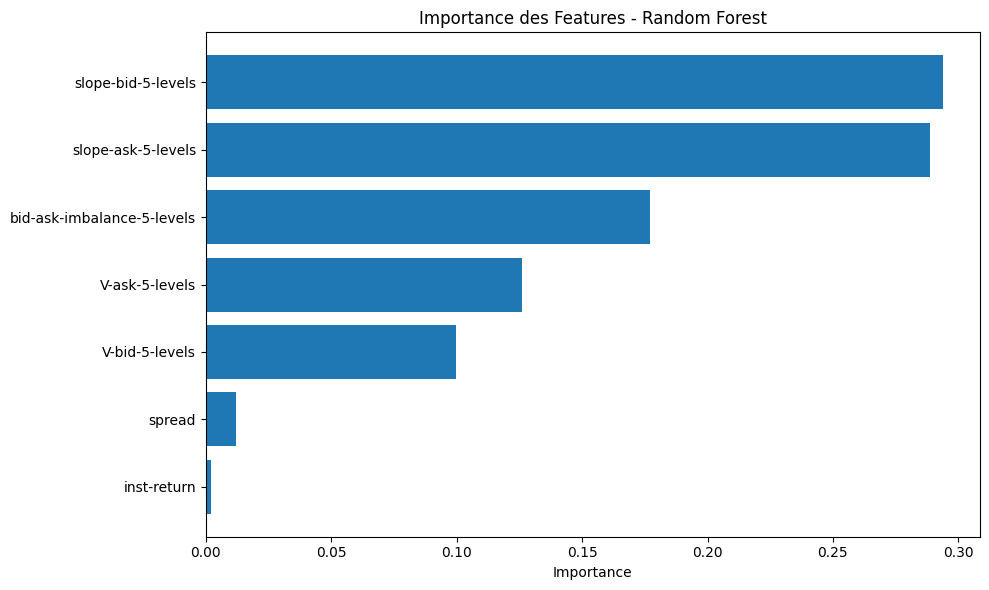

In [17]:
# Analyse et visualisation des importances des features
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== IMPORTANCE DES FEATURES ===")
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Importance des Features - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

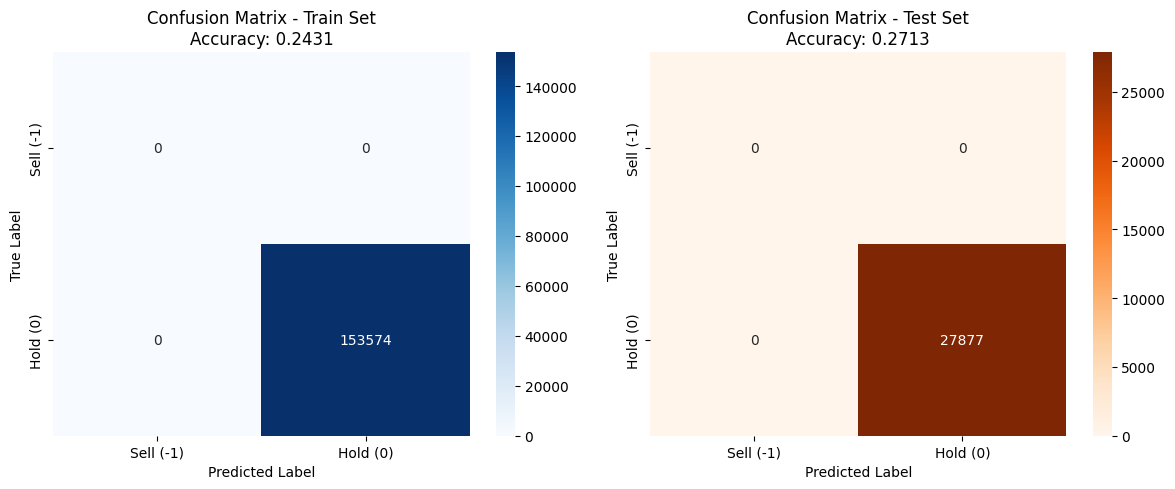

In [18]:
# Visualisation des matrices de confusion
plt.figure(figsize=(12, 5))

# Matrice de confusion pour le train set
plt.subplot(1, 2, 1)
cm_train = confusion_matrix(y_train, y_train_pred, labels=[-1, 0])
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sell (-1)', 'Hold (0)'], 
            yticklabels=['Sell (-1)', 'Hold (0)'])
plt.title(f'Confusion Matrix - Train Set\nAccuracy: {train_acc:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Matrice de confusion pour le test set
plt.subplot(1, 2, 2)
cm_test = confusion_matrix(y_test, y_pred, labels=[-1, 0])
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Sell (-1)', 'Hold (0)'], 
            yticklabels=['Sell (-1)', 'Hold (0)'])
plt.title(f'Confusion Matrix - Test Set\nAccuracy: {test_acc:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

In [19]:
# Statistiques finales et sauvegarde du modèle
print("\n=== STATISTIQUES FINALES ===")
print(f"Nombre total d'échantillons d'entraînement: {len(X_train)}")
print(f"Nombre total d'échantillons de test: {len(X_test)}")
print(f"Nombre de features: {X_train.shape[1]}")
print(f"Features utilisées: {list(feature_columns)}")
print(f"Classes dans le dataset: {sorted(np.unique(y_train))}")

print(f"\nPerformances du modèle Random Forest final:")
print(f"- Train Accuracy: {train_acc:.4f}")
print(f"- Test Accuracy: {test_acc:.4f}")
print(f"- Feature la plus importante: {feature_importance.iloc[0]['feature']} ({feature_importance.iloc[0]['importance']:.4f})")

# Sauvegarde du modèle
os.makedirs("../../predictors/mateo", exist_ok=True)
model_path = "../../predictors/mateo/rf_model_5ms_clean.joblib"
joblib.dump(rf_model, model_path)
print(f"\nModèle sauvegardé dans '{model_path}'")

print("\n=== ANALYSE TERMINÉE ===")


=== STATISTIQUES FINALES ===
Nombre total d'échantillons d'entraînement: 1454148
Nombre total d'échantillons de test: 363537
Nombre de features: 7
Features utilisées: ['bid-ask-imbalance-5-levels', 'spread', 'inst-return', 'V-bid-5-levels', 'V-ask-5-levels', 'slope-bid-5-levels', 'slope-ask-5-levels']
Classes dans le dataset: [np.int64(0), np.int64(1)]

Performances du modèle Random Forest final:
- Train Accuracy: 0.2431
- Test Accuracy: 0.2713
- Feature la plus importante: slope-bid-5-levels (0.2939)

Modèle sauvegardé dans '../../predictors/mateo/rf_model_5ms_clean.joblib'

=== ANALYSE TERMINÉE ===
